# Network-Based Statistic with fMRI connectivity data

In [1]:
from nilearn.connectome import ConnectivityMeasure
from nilearn.maskers import NiftiMapsMasker
from nilearn import plotting
from nilearn import datasets

from scipy.spatial.distance import squareform
import numpy as np

from niseq import sequential_cluster_test_indep

Before we get started, we'll load some example functional connectivity data from [Richardson et al. (2018)](https://doi.org/10.1038/s41467-018-03399-2). The dataset contains BOLD timeseries recorded during movie watching, including adults (ages 18-39) and children (ages 3-12).

In [2]:
# load example dataset
development_dataset = datasets.fetch_development_fmri()
groups = [pheno['Child_Adult'] for pheno in development_dataset.phenotypic]
groups = np.array(groups)

# extract ROI's
msdl_data = datasets.fetch_atlas_msdl()
msdl_coords = msdl_data.region_coords
masker = NiftiMapsMasker(
    msdl_data.maps,
    resampling_target = "data", 
    t_r = 2, 
    detrend = True,
    low_pass = .1, 
    high_pass = .01, 
    memory = 'nilearn_cache', 
    memory_level = 1
).fit()
masked_data = [
    masker.transform(func, confounds) 
    for (func, confounds) 
    in zip(development_dataset.func, development_dataset.confounds)
]

# and compute all-to-all connectivity matrix
conn = ConnectivityMeasure(kind = 'correlation').fit_transform(masked_data)
n_rois = conn.shape[1]
conn.shape

(155, 39, 39)

In [3]:
## vectorize connectivity matrices
conn = np.stack([squareform(c, checks = False) for c in conn])
conn.shape

(155, 741)

 One more thing: the dataset, as we just loaded it from `nilearn`, is ordered such that all the children appear in the dataset before any adults do. For this example, we want them mixed together, so we'll shuffle the observations (and downsample to equally sized groups) for illustration purposes _only_. For real applications, the data in in `X` __must appear in the order in which the data are collected.__ 

In [4]:
## downsample to equally sized groups (just for illustration)
X = np.arctanh(conn) # Fisher z-transform the correlations in conn
x1 = X[groups == 'child'][:30]
x2 = X[groups == 'adult'][:30] 
X = np.concatenate([x1, x2])
y = [np.repeat('child', x1.shape[0]), np.repeat('adult', x2.shape[0])]
y = np.concatenate(y)

# shuffle observations so that children/adults are mixed together
np.random.seed(0)
n_max = X.shape[0] 
idxs = np.arange(n_max)
np.random.shuffle(idxs)
X = X[idxs]
y = y[idxs]

In [5]:
X.shape # shape should be (n_subjects, n_edges)

(60, 741)

In [6]:
y.shape # condition labels, shape should be (n_subjects,)

(60,)

To start, we'll want to define a notion of adjacency. As in the computation of the original [network-based statistic](https://doi.org/10.1016/j.neuroimage.2010.06.041) used for comparing group-level functional connectivity data, we'll say two edges are adjacent if they share a node. That way, when we look for "clusters" of edges, we'll in fact be looking for subnetworks of connected components.

The somewhat clunky function below will do what we need, given the number of nodes (ROIs) as input:

In [7]:
def make_edge_adjacency_matrix(n_nodes):
    '''Contruct adjacency matrix for connected edges.
    
    Parameters
    ----------
    n_nodes : int
        Number of nodes (i.e. regions of interest)
    
    Returns
    ----------
    adjacency : scipy.sparse.spmatrix of shape (n_edges, n_edges)
        ``adjacency[i][j]`` is equal to 1 when edges i and j are
        both connected to a shared node, 0 otherwise.
        
    '''
    from itertools import combinations
    from scipy import sparse
    # get squareform node indices for vectorized matrix
    node_idxs = np.array(list(combinations(range(n_nodes), 2)))
    n_edges = node_idxs.shape[0]
    neighb_lists = []
    for e in range(n_edges): # for each edge...
        # find all edges that share a node
        shares_first_node = np.any(node_idxs == node_idxs[e][0], 1)
        shares_second_node = np.any(node_idxs == node_idxs[e][1], 1)
        shares_node = np.logical_or(shares_first_node, shares_second_node)
        neighb_lists.append(shares_node) # and call them neighbors
    # combine neighbor lists into 2D adjacency matrix
    adj = np.array(neighb_lists)
    # and sparsify for downstream efficiency / MNE compatibility
    return sparse.csr_matrix(adj)

adj = make_edge_adjacency_matrix(n_rois)
adj

<741x741 sparse matrix of type '<class 'numpy.bool_'>'
	with 55575 stored elements in Compressed Sparse Row format>

Again, the network-based statistic (NBS) procedure is just a cluster-based permutation test where contiguous sets of edges/connections are considered instead of contiguous voxels or sensors -- so we can use the `sequential_cluster_test_indep` for an independent samples test. In the traditional implementation of NBS, the number of edges in a connected subnetwork is used as a test statistic, but `sequential_cluster_test_indep` uses the sum of node-wise test statistics within a cluster/subnetwork by default. We can change that behavior to match NBS by setting `t_power = 0`.

In [8]:
## perform sequential permutation test using network-based statistic 

look_times = [n_max//3, 2*n_max//3, n_max] # we'll do three looks at the data

obs_stats, ps, adj_alpha, spending = sequential_cluster_test_indep(
    X, y, 
    look_times, n_max, 
    adjacency = adj,
    threshold = 10, # arbitrary!
    t_power = 0, # use count of connected components as cluster stat
    out_type = 'mask',
    n_jobs = -1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 962 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 1024 out of 1024 | elapsed:    6.2s finished


In [9]:
for reject, n in zip(ps <= adj_alpha, look_times):
    if reject:
        print('rejected at n = %d/%d'%(n, n_max))
    else:
        print('not rejected at n = %d/%d'%(n, n_max))

not rejected at n = 20/60
rejected at n = 40/60
rejected at n = 60/60


It looks like, in this example, we would've rejected the null hypothesis at $n = 40$, so we could've stopped data collection there instead of collecting until $n = n_\max = 60$.

In [10]:
n = look_times[1]
t_obs, clusters, cluster_pv, H0 = obs_stats[n]
sig_clusts = [clust for i, clust in enumerate(clusters) if cluster_pv[i] < adj_alpha[-1]]
cluster_mask = np.any(np.stack(sig_clusts), axis = 0)
print('Null hypothesis rejected on the basis of %d subnetwork at n = %d.'%(len(sig_clusts), n))

Null hypothesis rejected on the basis of 1 subnetwork at n = 40.


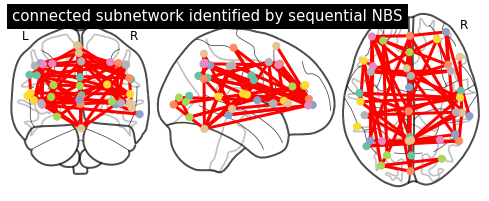

In [11]:
subnets = squareform(cluster_mask.astype(int)) # return to matrix form
fig = plotting.plot_connectome(
    subnets, msdl_coords,
    title = 'connected subnetwork identified by sequential NBS'
)